# The problem

Based on this dataset with 20,000 chess matches collected from Lichess (games taken of users from the top ~100 teams on _lichess.org_ from 2013 to 2017) the objective is to create a model that predicts the result of a match, given the parameters of the game, before it starts (available at https://www.kaggle.com/datasnaek/chess).

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
%pylab inline

pd.set_option('display.max_columns', 200)

Populating the interactive namespace from numpy and matplotlib


Importing the dataset:

In [2]:
chess_games = pd.read_csv('../games.csv', delimiter=',')

In [3]:
chess_games.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


## Features

### Duration of the match

In [4]:
games_delay_in_sec = (chess_games['last_move_at'] - chess_games['created_at']) / 1000
chess_games['duration_in_seconds'] = games_delay_in_sec.copy()

### One-Hot-Encoding of victory status

In [5]:
from category_encoders import OneHotEncoder

In [6]:
ohe_victory_status = OneHotEncoder(cols=['victory_status'], use_cat_names=True, drop_invariant=True)
chess_games = ohe_victory_status.fit_transform(chess_games)

### Time control: Minutes and Seconds

In [7]:
minutes = chess_games['increment_code'].str.split('+').map(lambda time_control: time_control[0], na_action=None).astype(int)
incr_seconds = chess_games['increment_code'].str.split('+').map(lambda time_control: time_control[1], na_action=None).astype(int)

chess_games['minutes'] = minutes.copy()
chess_games['incr_seconds'] = incr_seconds.copy()

In [8]:
chess_games = chess_games.drop(columns=['increment_code'], axis=1)

### Date of Creation and Last Move At (as dates)

In [9]:
chess_games['created_at'] = pd.to_datetime(chess_games['created_at'], unit='ms')
chess_games['last_move_at'] = pd.to_datetime(chess_games['last_move_at'], unit='ms')

### Rating difference

One other variable that seems to be predictive is the rating difference between the players.

In [10]:
chess_games['rating_difference'] = chess_games['white_rating'] - chess_games['black_rating']

In [11]:
chess_games['rating_difference'].mean()

7.799880346993718

### Castle

In [12]:
def get_white_moves(moves):
    return moves[::2]

def get_black_moves(moves):
    return moves[1::2]

def castled(moves):
    return ('O-O' in moves) | ('O-O-O' in moves)

all_moves = chess_games['moves'].str.split()
white_moves = all_moves.apply(get_white_moves)
black_moves = all_moves.apply(get_black_moves)
chess_games['white_castled'] = white_moves.apply(castled).astype(int)
chess_games['black_castled'] = black_moves.apply(castled).astype(int)

### Number of takes

In [13]:
def count_takes(moves):
    moves = pd.Series(moves)
    return moves.map(lambda mv: 1 if 'x' in mv else 0).sum()

chess_games['white_takes_count'] = white_moves.apply(count_takes)
chess_games['black_takes_count'] = black_moves.apply(count_takes)

In [14]:
chess_games.head()

,id,rated,created_at,last_move_at,turns,victory_status_outoftime,victory_status_resign,victory_status_mate,victory_status_draw,winner,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply,duration_in_seconds,minutes,incr_seconds,rating_difference,white_castled,black_castled,white_takes_count,black_takes_count
0,TZJHLljE,False,2017-08-31 20:06:40,2017-08-31 20:06:40,13,1,0,0,0,white,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5,0.0,15,2,309,0,0,2,1
1,l1NXvwaE,True,2017-08-30 21:53:20,2017-08-30 21:53:20,16,0,1,0,0,black,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4,0.0,5,10,61,0,0,2,3
2,mIICvQHh,True,2017-08-30 21:53:20,2017-08-30 21:53:20,61,0,0,1,0,white,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3,0.0,5,10,-4,0,0,14,3
3,kWKvrqYL,True,2017-08-30 16:20:00,2017-08-30 16:20:00,61,0,0,1,0,white,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3,0.0,20,0,-15,1,1,10,4
4,9tXo1AUZ,True,2017-08-29 18:06:40,2017-08-29 18:06:40,95,0,0,1,0,white,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5,0.0,30,3,54,1,1,14,10


## Clean Data

In [15]:
max_minutes = chess_games['minutes'].max()
max_incr_seconds = chess_games['incr_seconds'].max()
mean_moves = chess_games['turns'].mean()

duration_threshold_in_hours = (max_minutes + max_incr_seconds / 60 * mean_moves) / 60
duration_threshold_in_hours

6.0232999302024135

In [16]:
chess_games = chess_games[chess_games['turns'] > 3]
chess_games_invalid_duration = chess_games[chess_games['duration_in_seconds'] >= duration_threshold_in_hours * 3600]
chess_games = chess_games[chess_games['duration_in_seconds'] < duration_threshold_in_hours * 3600]

In [17]:
chess_games.shape

(19766, 26)

In [18]:
chess_games_invalid_duration.shape

(2, 26)

In [19]:
duration0 = chess_games[chess_games['duration_in_seconds'] == 0]
duration0['winner'].value_counts()

white    4207
black    3910
draw      355
Name: winner, dtype: int64

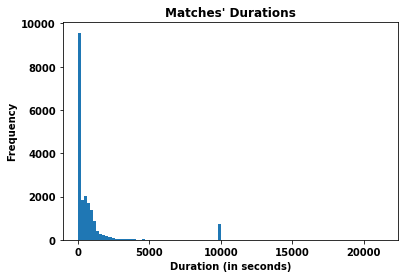

In [20]:
pyplot.hist(x=chess_games['duration_in_seconds'], bins=100)
pyplot.xlabel('Duration (in seconds)')
pyplot.ylabel('Frequency')
pyplot.title('Matches\' Durations')
pyplot.show()

Let's separate the matches that duration_in_seconds == 0.

In [21]:
chess_games_invalid_duration = pd.concat([chess_games_invalid_duration, duration0], ignore_index=False)
chess_games = chess_games[chess_games['duration_in_seconds'] > 0]

In [22]:
chess_games.shape

(11294, 26)

In [23]:
chess_games_invalid_duration.shape

(8474, 26)

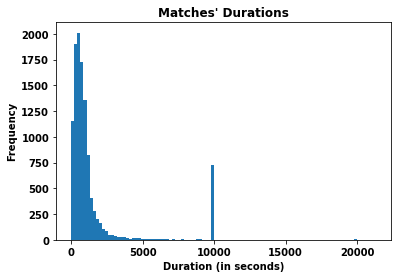

In [24]:
pyplot.hist(x=chess_games['duration_in_seconds'], bins=100)
pyplot.xlabel('Duration (in seconds)')
pyplot.ylabel('Frequency')
pyplot.title('Matches\' Durations')
pyplot.show()

For our first analysis, we'll consider the dataset 'chess_games' and 'chess_games_invalid_duration' (this one without the 'duration_in_seconds' fields).

The peak at ~10000 s = ~2.7 hours, which is a plausible match duration.

## Baseline

Let's take as **baseline case** the result as a function of the rating difference:

If
* the modulus difference is less than _mean difference_ points => draw;
* else, the difference is negative => black wins
* else => white wins

In [25]:
all_matches = pd.concat([chess_games.copy(), chess_games_invalid_duration.copy()])
baseline = pd.DataFrame(index=all_matches.index)
baseline['rating_difference'] = all_matches['rating_difference']
baseline.shape

(19768, 1)

In [26]:
baseline['rating_difference'].mean()

7.517300687980574

In [27]:
def get_base_winner(rating_diff):
    if rating_diff < 7.5 and rating_diff > -7.5:
        return 'draw'
    elif rating_diff < 0:
        return 'black'
    else:
        return 'white'

baseline['winner'] = baseline['rating_difference'].apply(get_base_winner)
baseline['winner'].value_counts()

white    9587
black    9111
draw     1070
Name: winner, dtype: int64

Let's use the **weighted avg precison** and **weighted avg recall** as our modeling metrics.

In [28]:
from sklearn.metrics import precision_recall_fscore_support, classification_report

In [29]:
print(classification_report(all_matches['winner'], baseline['winner'], digits=4))

              precision    recall  f1-score   support

       black     0.6074    0.6160    0.6117      8984
        draw     0.0551    0.0630    0.0588       937
       white     0.6446    0.6276    0.6360      9847

    accuracy                         0.5956     19768
   macro avg     0.4357    0.4355    0.4355     19768
weighted avg     0.5998    0.5956    0.5976     19768



p 0.5998, auc 0.5956 - Baseline

In [30]:
results = precision_recall_fscore_support(all_matches['winner'], baseline['winner'])
np.average(results[0], weights=results[3])

0.5997636996371806

weighted_avg_precision = weighted_avg(precision, support)

## Cross-validation

As the dataset is small, let's divide 50% train / 50% validation in each fold.

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedKFold

In [32]:
variables = ['victory_status_outoftime', 'victory_status_resign', 'victory_status_mate', 'victory_status_draw', 
             'white_rating', 'black_rating', 'minutes', 'incr_seconds', 'rating_difference', 
             'white_castled', 'black_castled', 'white_takes_count', 'black_takes_count']

In [33]:
avg_weighted_precisions = []
avg_weighted_recalls = []
kf = RepeatedKFold(n_splits=2, n_repeats=10, random_state=0)

X = all_matches[variables]
y = all_matches['winner']
i = 0

for lines_train, lines_valid in kf.split(all_matches):
    X_train, y_train = X.iloc[lines_train], y.iloc[lines_train]
    X_valid, y_valid = X.iloc[lines_valid], y.iloc[lines_valid]
    i = i + 1
    
    model = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=0)
    model.fit(X_train, y_train)
    
    predicted = model.predict(X_valid)

    results = precision_recall_fscore_support(y_valid, predicted)
    support = results[3]
    prec = np.average(results[0], weights=support)
    recall = np.average(results[1], weights=support)
    print("Iteration {}".format(i))
    print("=====================")
    print("Precision: {}".format(prec))
    print("Recall: {}".format(recall))
    print()
    
    avg_weighted_precisions.append(prec)
    avg_weighted_recalls.append(recall)

print("Average Precision: {}".format(np.mean(avg_weighted_precisions)))
print("Average Recall: {}".format(np.mean(avg_weighted_recalls)))

Iteration 1
Precision: 0.8147405156517191
Recall: 0.8143464184540672

Iteration 2
Precision: 0.8225282762547952
Recall: 0.8221367867260219

Iteration 3
Precision: 0.8227088624000376
Recall: 0.8223391339538648

Iteration 4
Precision: 0.8168855581028033
Recall: 0.8166734115742614

Iteration 5
Precision: 0.8183107873234557
Recall: 0.8180898421691623

Iteration 6
Precision: 0.8206534310076344
Recall: 0.820315661675435

Iteration 7
Precision: 0.8202472395919369
Recall: 0.8199109672197491

Iteration 8
Precision: 0.813817332604229
Recall: 0.8136382031566167

Iteration 9
Precision: 0.8213698358810653
Recall: 0.820922703358964

Iteration 10
Precision: 0.8144150973498077
Recall: 0.8139417239983813

Iteration 11
Precision: 0.8161888559767039
Recall: 0.8158640226628895

Iteration 12
Precision: 0.8206048559235652
Recall: 0.8203156616754349

Iteration 13
Precision: 0.8156614769495771
Recall: 0.8152569809793606

Iteration 14
Precision: 0.8251550121683621
Recall: 0.8247673006879805

Iteration 15
Preci

(array([4., 2., 3., 2., 0., 2., 3., 2., 1., 1.]),
 array([0.81381733, 0.8149511 , 0.81608487, 0.81721864, 0.8183524 ,
        0.81948617, 0.82061994, 0.82175371, 0.82288748, 0.82402124,
        0.82515501]),
 <a list of 10 Patch objects>)

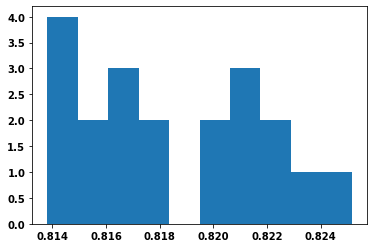

In [34]:
pylab.hist(avg_weighted_precisions)

The metrics are both above the baseline!

p 0.5998, recall 0.5956 - Baseline

p 0.6554, recall 0.6549 - Random Forest

p 0.6585, recall 0.6580 - Random Forest (n=200) with 'castled' variables

p 0.8186, recall 0.8182 - Random Forest (n=200) with 'castled' and 'takes_count' variables

## Error Analysis

In [35]:
X_valid['winner'] = y_valid
X_valid['predicted'] = predicted

error = X_valid[X_valid['winner'] != X_valid['predicted']]
error

C:\Users\marco\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\marco\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,victory_status_outoftime,victory_status_resign,victory_status_mate,victory_status_draw,white_rating,black_rating,minutes,incr_seconds,rating_difference,white_castled,black_castled,white_takes_count,black_takes_count,winner,predicted
157,0,1,0,0,1833,1863,15,0,-30,1,1,8,8,white,black
171,0,1,0,0,1848,1806,5,5,42,1,1,10,9,black,white
225,0,0,1,0,1240,1219,20,5,21,0,0,11,11,white,black
412,0,0,1,0,1612,1450,20,0,162,1,0,4,6,white,black
450,0,0,1,0,1509,1487,10,0,22,1,1,7,6,black,white
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9236,0,0,1,0,1271,1346,11,11,-75,0,1,6,6,white,black
9243,0,1,0,0,1529,1247,10,0,282,1,1,11,8,black,white
9261,0,1,0,0,1711,1631,20,0,80,1,1,8,9,white,black
9271,0,1,0,0,1302,1585,10,0,-283,0,0,2,2,white,black


((array([  8.,  81., 219., 450., 396., 331., 186.,  64.,  12.,   7.]),
  array([ 793. ,  975.8, 1158.6, 1341.4, 1524.2, 1707. , 1889.8, 2072.6,
         2255.4, 2438.2, 2621. ]),
  <a list of 10 Patch objects>),
 (array([  80.,  508., 1440., 2960., 2738., 1971., 1050.,  428.,   86.,
           33.]),
  array([ 788. ,  979.2, 1170.4, 1361.6, 1552.8, 1744. , 1935.2, 2126.4,
         2317.6, 2508.8, 2700. ]),
  <a list of 10 Patch objects>))

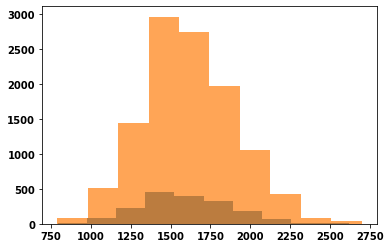

In [36]:
pylab.hist(error['white_rating']), pylab.hist(chess_games['white_rating'], alpha=0.7)

((array([ 16.,  99., 245., 449., 414., 289., 164.,  61.,  14.,   3.]),
  array([ 845. , 1022.6, 1200.2, 1377.8, 1555.4, 1733. , 1910.6, 2088.2,
         2265.8, 2443.4, 2621. ]),
  <a list of 10 Patch objects>),
 (array([  94.,  406., 1369., 2716., 2671., 2097., 1220.,  563.,  123.,
           35.]),
  array([ 789. ,  972.2, 1155.4, 1338.6, 1521.8, 1705. , 1888.2, 2071.4,
         2254.6, 2437.8, 2621. ]),
  <a list of 10 Patch objects>))

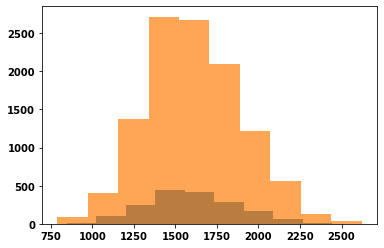

In [37]:
pylab.hist(error['black_rating']), pylab.hist(chess_games['black_rating'], alpha=0.7)

((array([  2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
           1.,   0.,   1.,   1.,   1.,   5.,   3.,   1.,   3.,   1.,   5.,
           4.,   2.,   2.,   5.,   2.,  10.,   8.,   6.,   9.,   6.,   9.,
           9.,  16.,  12.,  17.,  17.,  28.,  28.,  30.,  27.,  49.,  38.,
          66.,  72.,  67.,  99.,  83., 120., 110., 110.,  82.,  69.,  52.,
          61.,  50.,  60.,  39.,  40.,  24.,  27.,  25.,   8.,  14.,  16.,
          16.,  12.,   9.,  12.,   3.,   8.,   4.,   7.,   4.,   7.,   1.,
           2.,   2.,   3.,   0.,   2.,   1.,   0.,   1.,   0.,   0.,   2.,
           4.]), array([-1.12100e+03, -1.10262e+03, -1.08424e+03, -1.06586e+03,
         -1.04748e+03, -1.02910e+03, -1.01072e+03, -9.92340e+02,
         -9.73960e+02, -9.55580e+02, -9.37200e+02, -9.18820e+02,
         -9.00440e+02, -8.82060e+02, -8.63680e+02, -8.45300e+02,
         -8.26920e+02, -8.08540e+02, -7.90160e+02,

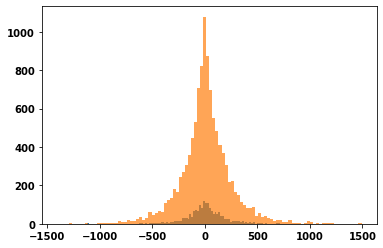

In [38]:
pylab.hist(error['rating_difference'], bins=100), pylab.hist(chess_games['rating_difference'], bins=100, alpha=0.7)

In [39]:
error['minutes'].value_counts(), chess_games['minutes'].value_counts()

(10     853
 15     291
 5      149
 8       93
 20      88
 30      65
 7       50
 25      28
 6       19
 9       18
 45      16
 12      11
 180     10
 13       9
 11       8
 4        7
 2        7
 3        5
 14       5
 60       5
 90       3
 35       3
 1        3
 17       2
 40       2
 16       1
 18       1
 19       1
 0        1
 Name: minutes, dtype: int64, 10     5391
 15     1831
 5       949
 8       527
 20      488
 30      463
 7       399
 25      216
 9       156
 12      140
 45      128
 6        80
 180      68
 60       60
 11       45
 4        37
 13       36
 14       35
 3        35
 16       29
 40       27
 0        26
 2        24
 1        20
 17       19
 19       15
 120      13
 18       10
 90       10
 150       7
 35        7
 29        2
 21        1
 Name: minutes, dtype: int64)

In [40]:
error['incr_seconds'].value_counts(), chess_games['incr_seconds'].value_counts()

(0      1001
 5       185
 10      112
 15       96
 8        88
 2        70
 3        38
 30       25
 1        24
 6        19
 7        13
 45       11
 12       11
 20       10
 14        9
 4         7
 60        7
 9         7
 180       5
 11        5
 17        2
 25        2
 40        2
 13        2
 16        1
 18        1
 19        1
 Name: incr_seconds, dtype: int64, 0      6148
 5      1189
 10      834
 15      685
 8       614
 2       389
 30      222
 3       219
 1       126
 6       110
 45      100
 7        94
 9        87
 60       83
 4        82
 20       69
 180      51
 25       40
 12       33
 40       24
 17       18
 14       17
 11       17
 16       11
 18       10
 13        7
 21        6
 19        3
 35        2
 120       2
 150       1
 90        1
 Name: incr_seconds, dtype: int64)

In [41]:
len(error[error['incr_seconds'] == 0])

1001

In [42]:
len(error[error['incr_seconds'] > 0])

753

In [43]:
#victory_status_outoftime 	victory_status_resign 	victory_status_mate 	victory_status_draw
error['victory_status_outoftime'].value_counts()

0    1481
1     273
Name: victory_status_outoftime, dtype: int64

In [44]:
chess_games['victory_status_outoftime'].value_counts()

0    10295
1      999
Name: victory_status_outoftime, dtype: int64

In [45]:
error[error['winner'] == 'draw']

,victory_status_outoftime,victory_status_resign,victory_status_mate,victory_status_draw,white_rating,black_rating,minutes,incr_seconds,rating_difference,white_castled,black_castled,white_takes_count,black_takes_count,winner,predicted
9130,1,0,0,0,1483,2005,25,0,-522,1,1,15,12,draw,white
13286,1,0,0,0,1308,1448,10,0,-140,1,1,15,14,draw,white
13622,1,0,0,0,1941,1775,10,0,166,1,1,14,15,draw,black
15909,1,0,0,0,1801,1858,10,0,-57,1,1,15,14,draw,white
16845,1,0,0,0,1466,1583,10,0,-117,1,1,15,12,draw,white
18402,1,0,0,0,1648,1785,10,0,-137,1,1,13,15,draw,black
18447,1,0,0,0,1554,1651,10,0,-97,1,1,11,15,draw,black
19825,1,0,0,0,1500,1500,8,0,0,1,1,10,15,draw,black
1220,1,0,0,0,1291,1166,10,0,125,1,1,9,15,draw,black
1812,1,0,0,0,1009,1038,8,0,-29,0,0,15,9,draw,white


Greatest quantity of errors in:

- absolute ratings (black and white) between 1200 and 1800
- some draws were wrongly predicted

## Variables Selection

We can look for the variables that together give a model which performs better.

In [46]:
import warnings
warnings.filterwarnings('ignore')

model = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=0)

accepted = []
max_avg_weighted_precision = 0.0
max_avg_weighted_recall = 0.0

for step in range(20):
    var_best_metrics = None
    for var in X_train.columns:
        if var in accepted:
            continue
        model.fit(X_train[accepted+[var]], y_train)
        predicted = model.predict(X_valid[accepted+[var]])

        results = precision_recall_fscore_support(y_valid, predicted)
        support = results[3]
        avg_prec = np.average(results[0], weights=support)
        avg_recall = np.average(results[1], weights=support)
        
        if (avg_prec > max_avg_weighted_precision) & (avg_recall > max_avg_weighted_recall):
            var_best_metrics = var
            max_avg_weighted_precision = avg_prec
            max_avg_weighted_recall = avg_recall
            
    if var_best_metrics is None:
        break
    accepted.append(var_best_metrics)
    
    print("Best Variable {} - Avg. Prec: {:.4f}% - Avg. Recall: {:.4f}%\n".format(var_best_metrics, max_avg_weighted_precision, max_avg_weighted_recall))
    print(accepted)
    print()

Best Variable rating_difference - Avg. Prec: 0.5663% - Avg. Recall: 0.5875%

['rating_difference']

Best Variable victory_status_draw - Avg. Prec: 0.6316% - Avg. Recall: 0.6319%

['rating_difference', 'victory_status_draw']

Best Variable white_rating - Avg. Prec: 0.6490% - Avg. Recall: 0.6482%

['rating_difference', 'victory_status_draw', 'white_rating']

Best Variable black_takes_count - Avg. Prec: 0.6688% - Avg. Recall: 0.6684%

['rating_difference', 'victory_status_draw', 'white_rating', 'black_takes_count']

Best Variable white_takes_count - Avg. Prec: 0.8185% - Avg. Recall: 0.8180%

['rating_difference', 'victory_status_draw', 'white_rating', 'black_takes_count', 'white_takes_count']

Best Variable incr_seconds - Avg. Prec: 0.8249% - Avg. Recall: 0.8244%

['rating_difference', 'victory_status_draw', 'white_rating', 'black_takes_count', 'white_takes_count', 'incr_seconds']

Best Variable victory_status_resign - Avg. Prec: 0.8270% - Avg. Recall: 0.8265%

['rating_difference', 'vict

p: 0.8304% - auc: 0.8298% - ['rating_difference', 'victory_status_draw', 'white_rating', 'black_takes_count', 'white_takes_count', 'incr_seconds', 'victory_status_resign', 'white_castled', 'victory_status_mate']